In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# make directory 2d
!mkdir 2d

In [3]:
# move into dir 2d
%cd 2d

/content/2d


### Downloading the dataset from [figshare.com/articles/brain_tumor_dataset/1512427](figshare.com/articles/brain_tumor_dataset/1512427)



In [4]:
# download data 
!wget https://ndownloader.figshare.com/articles/1512427/versions/5

--2022-07-22 04:32:15--  https://ndownloader.figshare.com/articles/1512427/versions/5
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.217.124.219, 52.16.102.173, 2a05:d018:1f4:d000:b283:27aa:b939:8ed4, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.217.124.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  28.4MB/s    in 31s     

2022-07-22 04:32:46 (27.3 MB/s) - ‘5’ saved [879501695/879501695]



In [5]:
# unzip downloaded file and remove prev file
!unzip 5 && rm 5

Archive:  5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [6]:
# merge extracted files into one file 
!cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip 

Fix archive (-FF) - salvage what can
 Found end record (EOCDR) - says expect single disk archive
Scanning for entries...
 copying: 1533.mat  (339637 bytes)
 copying: 1534.mat  (340418 bytes)
 copying: 1535.mat  (342222 bytes)
 copying: 1536.mat  (342920 bytes)
 copying: 1537.mat  (343484 bytes)
 copying: 1538.mat  (323526 bytes)
 copying: 1539.mat  (326770 bytes)
 copying: 1540.mat  (328641 bytes)
 copying: 1541.mat  (331088 bytes)
 copying: 1542.mat  (333075 bytes)
 copying: 1543.mat  (335548 bytes)
 copying: 1544.mat  (337196 bytes)
 copying: 1545.mat  (265792 bytes)
 copying: 1546.mat  (266357 bytes)
 copying: 1547.mat  (267792 bytes)
 copying: 1548.mat  (269198 bytes)
 copying: 1549.mat  (267728 bytes)
 copying: 1550.mat  (265932 bytes)
 copying: 1551.mat  (264956 bytes)
 copying: 1552.mat  (262235 bytes)
 copying: 1553.mat  (262966 bytes)
 copying: 1554.mat  (263969 bytes)
 copying: 1555.mat  (264622 bytes)
 copying: 1556.mat  (264585 bytes)
 copying: 1557.mat  (347465 bytes)
 cop

In [7]:
# remove prev files
!rm brainTumorDataPublic_*

In [8]:
# unzip main file and remove after extracting data
!unzip data.zip -d data && rm data.zip

Archive:  data.zip
  inflating: data/1533.mat           
  inflating: data/1534.mat           
  inflating: data/1535.mat           
  inflating: data/1536.mat           
  inflating: data/1537.mat           
  inflating: data/1538.mat           
  inflating: data/1539.mat           
  inflating: data/1540.mat           
  inflating: data/1541.mat           
  inflating: data/1542.mat           
  inflating: data/1543.mat           
  inflating: data/1544.mat           
  inflating: data/1545.mat           
  inflating: data/1546.mat           
  inflating: data/1547.mat           
  inflating: data/1548.mat           
  inflating: data/1549.mat           
  inflating: data/1550.mat           
  inflating: data/1551.mat           
  inflating: data/1552.mat           
  inflating: data/1553.mat           
  inflating: data/1554.mat           
  inflating: data/1555.mat           
  inflating: data/1556.mat           
  inflating: data/1557.mat           
  inflating: data/1558.mat     

In [9]:
# show total no of extracted files
!ls data | wc -l

3064


In [10]:
!pip install hdf5storage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 


### Creating images, labels and mass numpy arrays 

In [11]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt

class NoDataFound(Exception):
    pass


def dir_path(path):
    """Check the path and the existence of a data directory"""
    # replace '\' in path for Windows users
    path = path.replace('\\', '/')
    data_path = os.path.join(path, 'data').replace('\\', '/')
    # check if data dir is present
    if os.path.isdir(data_path):
        return path
    # if not, then raise the error
    elif os.path.isdir(path):
        raise NoDataFound('Could not find a "data" folder inside directory. {} does not exist.'
                          .format(data_path))
    else:
        raise NotADirectoryError(path)

path='.'
parser = argparse.ArgumentParser()
parser.add_argument('path', help='path to the brain_tumor_dataset directory', type=dir_path)
parser.add_argument('--image-dimension', '-d', default=256, help='dimension of the image', type=int)
args = parser.parse_args(args=[path])

# lists to store data
labels = []
images = []
masks = []
# data dir which contains mat files
data_dir = os.path.join(args.path, 'data').replace('\\', '/')
# list all the files in data dir
files = os.listdir(data_dir)
# loop through the files
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(args.image_dimension, args.image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(args.image_dimension, args.image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    # add image and mask to lists
    labels.append(int(mat_file[0]))
    images.append(image)
    masks.append(mask.astype(bool))


sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

# convert lists to numpy arrays
labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

# save numpy arrays
np.save(os.path.join(args.path, 'labels.npy'), labels)
np.save(os.path.join(args.path, 'images_256.npy'), images)
np.save(os.path.join(args.path, 'masks_256.npy'), masks)

print('labels.npy, images.npy, masks.npy saved in', args.path)

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 256, 256)
masks: (3064, 256, 256)
labels.npy, images.npy, masks.npy saved in .


In [12]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'} 

In [13]:
# load numpy arrays
labels = np.load('labels.npy')
images = np.load('images_256.npy')
masks = np.load('masks_256.npy')

print(labels.shape)
print(images.shape)
print(masks.shape) 

(3064,)
(3064, 256, 256)
(3064, 256, 256)


### Data Visualizations

<BarContainer object of 3 artists>

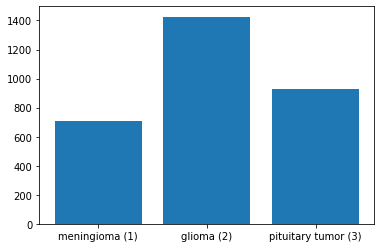

In [14]:
# get unique categories and their quantity in data
classes, counts = np.unique(labels, return_counts=True)
# plot the bar graph
plt.bar(classes, counts, 
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])


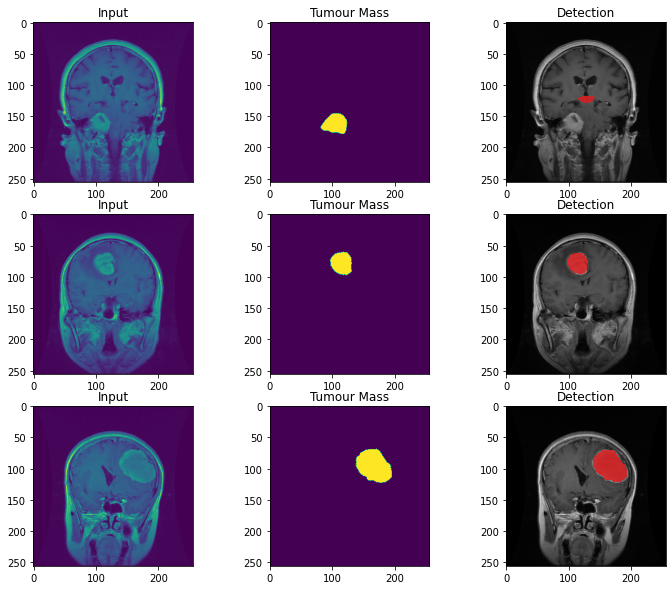

In [15]:
# make a figure
plt.figure(figsize=(12, 10))

# plot image 1
plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(images[6,:])

# plot mask 1
plt.subplot(3,3,2)
plt.title('Tumour Mass')
plt.imshow(masks[6,:])

# overlay mask 1 on image 1
plt.subplot(3,3,3)
plt.title('Detection')
plt.imshow(images[6,:],cmap='gray')
mask = np.ma.masked_where(masks[0] == False, masks[0])
plt.imshow(mask, alpha=0.8, cmap='Set1')
  
# plot image 2
plt.subplot(3,3,4)
plt.title('Input')
plt.imshow(images[1,:])

# plot mask 2
plt.subplot(3,3,5)
plt.title('Tumour Mass')
plt.imshow(masks[1,:])

# overlay mask 2 on image 2
plt.subplot(3,3,6)
plt.title('Detection')
plt.imshow(images[1,:],cmap='gray')
mask = np.ma.masked_where(masks[1] == False, masks[1])
plt.imshow(mask, alpha=0.8, cmap='Set1')

# plot image 3
plt.subplot(3,3,7)
plt.title('Input')
plt.imshow(images[2,:])

# plot mask 3
plt.subplot(3,3,8)
plt.title('Tumour Mass')
plt.imshow(masks[2,:])

# overlay mask 3 on image 3
plt.subplot(3,3,9)
plt.title('Detection')
plt.imshow(images[2,:],cmap='gray')
mask = np.ma.masked_where(masks[2] == False, masks[2])
plt.imshow(mask, alpha=0.8, cmap='Set1')
  
  


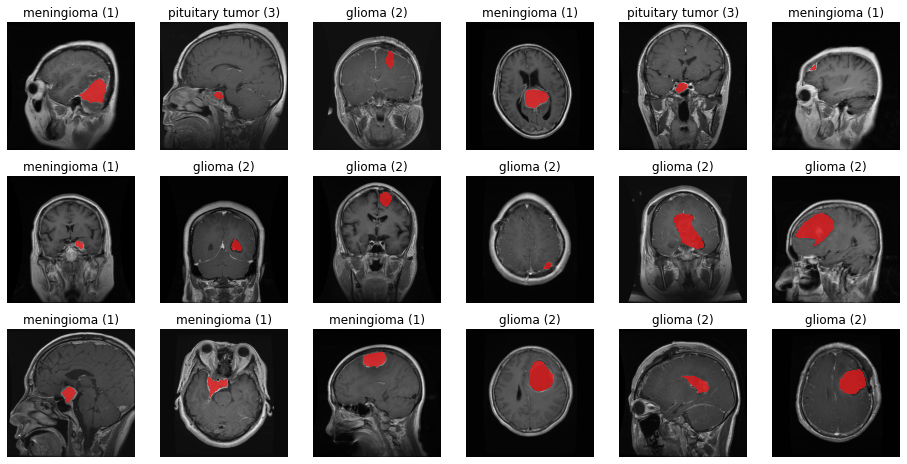

In [16]:
# make a figure
plt.figure(figsize=(16, 8))
# loop through the data
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    # make subplot for image
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')
    
    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.8, cmap='Set1')
    
    # set the title of subplot
    plt.title(integer_to_class[str(labels[idx])])
    # turn image axis off
    plt.axis('off')